# ARIMA Model

1. ADFuller Test (Stationarity Test)
2. Differencing
3. ACF and PACF Plots
4. Spliting data into Train and Test set
5. Model Training
6. Prediction
7. Model Evaluation
8. Retrain and forecast the future

<Strong><a href="http://datagyani.in/index.php/2021/09/01/analyze-time-series-data/">HOW TO ANALYZE TIME SERIES DATA…</a></Strong>

In [90]:
#let's import all the neccessary libraries
import pandas as pd # data processing
import numpy as np # data processing
import os #helps changing directory and locating your file
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from statsmodels.tools.eval_measures import rmse #evaluation metric

In [15]:
#changing directory
os.chdir('D:\\blog/Time Series')
os.getcwd()

'D:\\blog\\Time Series'

In [49]:
#reading the dataset
df = pd.read_csv('Inventory_dataset.csv',index_col='Date',parse_dates=True)
#dropping NA if any in the dataset
df.dropna(inplace=True)
df.index.freq='MS'
#printing the  the first five column
df.tail()

,Inventories
Date,
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639
2018-11-01,2143001
2018-12-01,2158115


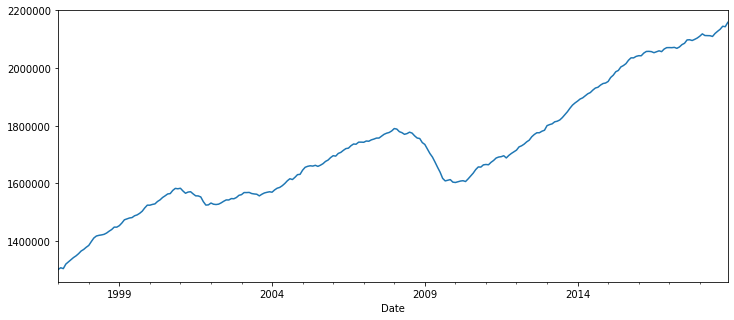

In [55]:
df['Inventories'].plot(figsize=(12,5));

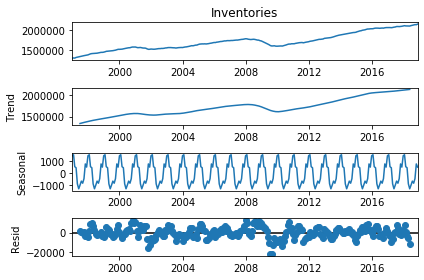

In [64]:
decomp = seasonal_decompose(df['Inventories'], model='add')  
decomp.plot();

Although dataset has some seasonality but its not very significant. Therefore, we will try Non seasonal Arima on it

We will use traditional method to find orders. Let's start with Stationarity.

<Strong>1. ADFuller Test </Strong>

We will use the function that we had created while understanding about ADFuller.

In [57]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [59]:
adf_test(df['Inventories'], "Inventory")

Augmented Dickey-Fuller Test: Inventory
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


<strong>2. Differencing </strong>

We will use differencing to transform data into stationary

In [61]:
df['diff1'] = diff(df['Inventories'],k_diff=1)
adf_test(df['diff1'], "Inventory")

Augmented Dickey-Fuller Test: Inventory
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is stationary


Our data becomes stationary after 1 order differencing. Hence, "d"= 1

<strong>3. ACF and PACF Plots</strong>

A PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders.

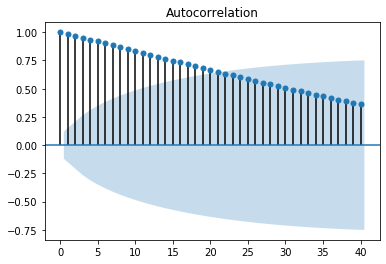

In [76]:
plot_acf(df['Inventories'],lags=40); #"q"=1

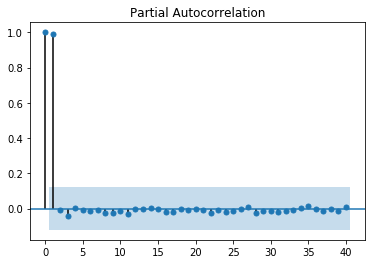

In [77]:
plot_pacf(df['Inventories'],lags=40);#"p"=0 or 1

<strong>4. Spliting data into Train and Test set</strong>

In [69]:
train = df.iloc[:252]
test = df.iloc[252:]

<strong>5. Model Training</strong>

In [99]:
#Fit the model as per orders
arima_model = ARIMA(train['Inventories'],order=(1,1,1))
model = arima_model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.394
Method:                       css-mle   S.D. of innovations           4845.003
Date:                Sun, 15 Nov 2020   AIC                           4980.787
Time:                        03:44:30   BIC                           4994.889
Sample:                    02-01-1997   HQIC                          4986.462
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3249.0071   1345.095      2.415      0.016     612.669    5885.345
ar.L1.D.Inventories     0.9026      0.039     23.012      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1079           +0.0000j            1.1079            0.0000
MA.1            1.7917           +0.0000j            1.7917            0.0000
-----------------------------------------------------------------------------
"""

<strong>6. Prediction</strong>

In [80]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions')

You click the link to know more about the above step https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

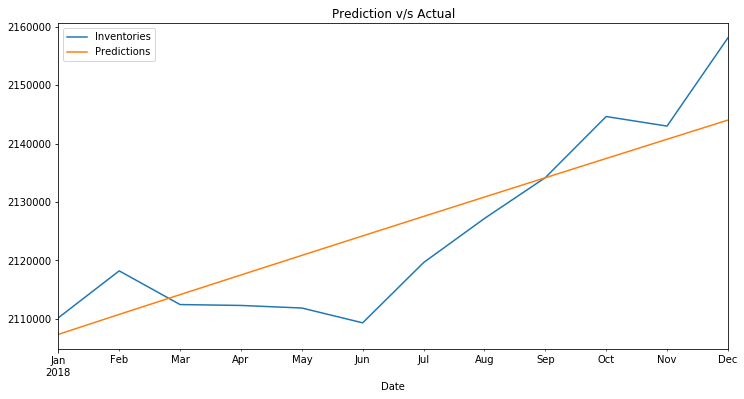

In [88]:
ax =test['Inventories'].plot(legend=True,figsize=(12,6),title="Prediction v/s Actual")
predictions.plot(legend=True)

<strong>7. Model Evaluation</strong>

In [91]:
RMSE = rmse(test['Inventories'], predictions)
print(f'RMSE Error: {RMSE}')

RMSE Error: 7790.129140395451


<strong>8. Retrain and forecast the future</strong>

In [95]:
f_model = ARIMA(df['Inventories'],order=(1,1,1))
arima_final = f_model.fit()
forecast = arima_final.predict(len(df),len(df)+11,typ='levels').rename('Forecast')

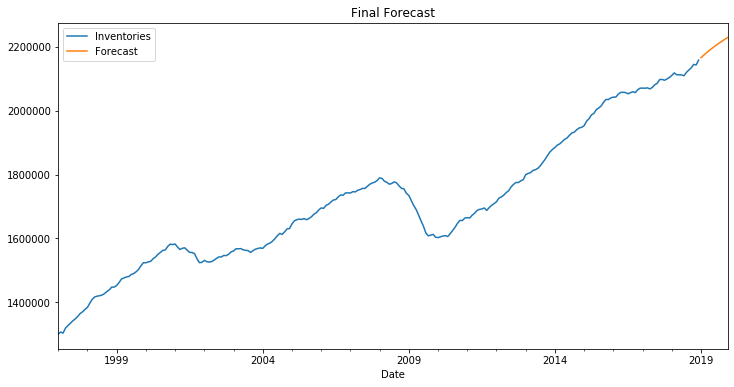

In [97]:
df['Inventories'].plot(legend=True,figsize=(12,6),title="Final Forecast")
forecast.plot(legend=True)

We probably can do better using Seasonal arima models but this is good enough for learning. We will use auto arima(grid search method) in hands for Seasonal arima model